# Business Case: Scaler learner's Clustering for better Segmentation and Profiling

### Scaler wants to segment their learners to offer better job opportunity and work with best companies based on their profile attribute like current job statues, existing company and exp etc.

## Importing Data and Required Libraries

In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
from category_encoders import TargetEncoder
from datetime import datetime as dt

In [ ]:
# !pip show scikit-learn

In [ ]:
with open('./scaler_clustering.csv', 'r') as file_obj:
    ncols = len(file_obj.readline().split(','))

print('Number of columns :', ncols)

scaler_df = pd.read_csv('scaler_clustering.csv', usecols=range(1, ncols))
scaler_df.head()

Number of columns : 7


,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


## Exploratory Data analysis

In [ ]:
scaler_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   email_hash        205843 non-null  object 
 2   orgyear           205757 non-null  float64
 3   ctc               205843 non-null  int64  
 4   job_position      153279 non-null  object 
 5   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.4+ MB


In [ ]:
scaler_df.describe()

,orgyear,ctc,ctc_updated_year
count,205757.000000,2.058430e+05,205843.000000
mean,2014.882750,2.271685e+06,2019.628231
std,63.571115,1.180091e+07,1.325104
min,0.000000,2.000000e+00,2015.000000
25%,2013.000000,5.300000e+05,2019.000000
50%,2016.000000,9.500000e+05,2020.000000
75%,2018.000000,1.700000e+06,2021.000000
max,20165.000000,1.000150e+09,2021.000000


In [ ]:
scaler_df.describe(include='object')

,company_hash,email_hash,job_position
count,205799,205843,153279
unique,37299,153443,1016
top,nvnv wgzohrnvzwj otqcxwto,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,Backend Engineer
freq,8337,10,43554


In [ ]:
print('% of NaNs in the features')
np.round(scaler_df.isna().sum()/len(scaler_df)*100, 2).astype('object')

% of NaNs in the features


company_hash         0.02
email_hash            0.0
orgyear              0.04
ctc                   0.0
job_position        25.54
ctc_updated_year      0.0
dtype: object

Total unique company_hash: 37299
Total unique job_position: 1016
Total unique orgyear: 77
Total unique ctc_updated_year: 7


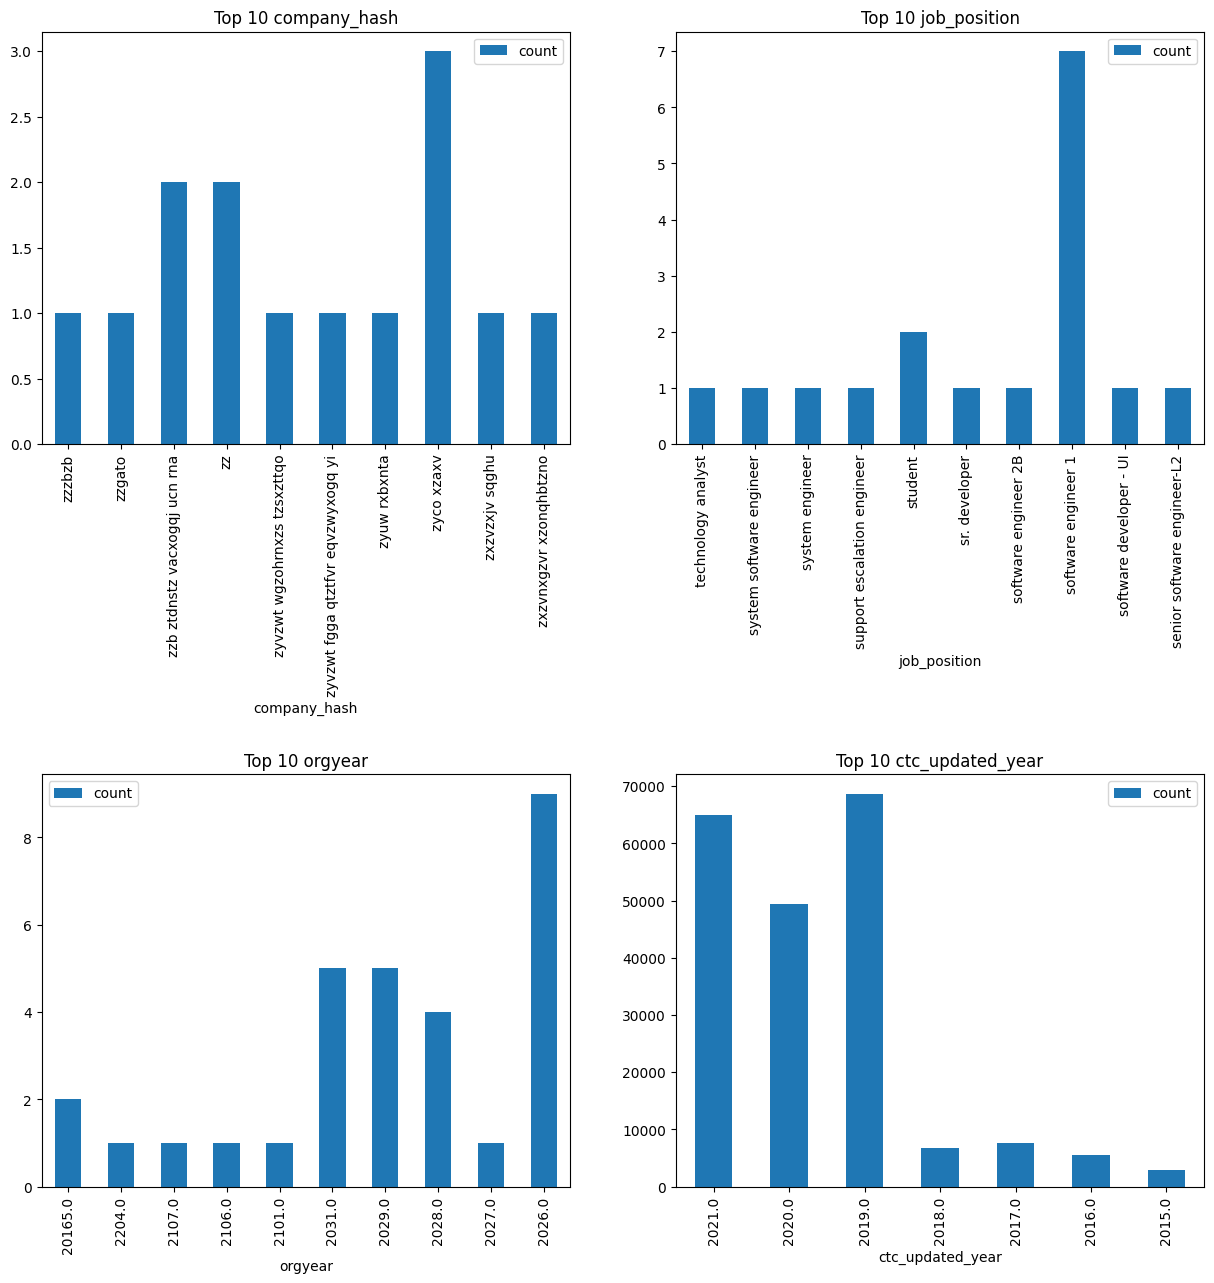

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
plt.subplots_adjust(hspace = .8)
categorical_features = ['company_hash', 'job_position', 'orgyear', 'ctc_updated_year']
for cnt, feature in enumerate(categorical_features):
    axes = ax[cnt//2, cnt%2]
    title = f'Top 10 {feature}'
    feature_count = pd.DataFrame(scaler_df[feature].value_counts()).sort_values(by=feature, ascending = False)
    print(f'Total unique {feature}:', len(feature_count))
    top10_datapoints = feature_count.head(10)
    top10_datapoints.plot(kind='bar', ax = axes, title = f'Top 10 {feature}')

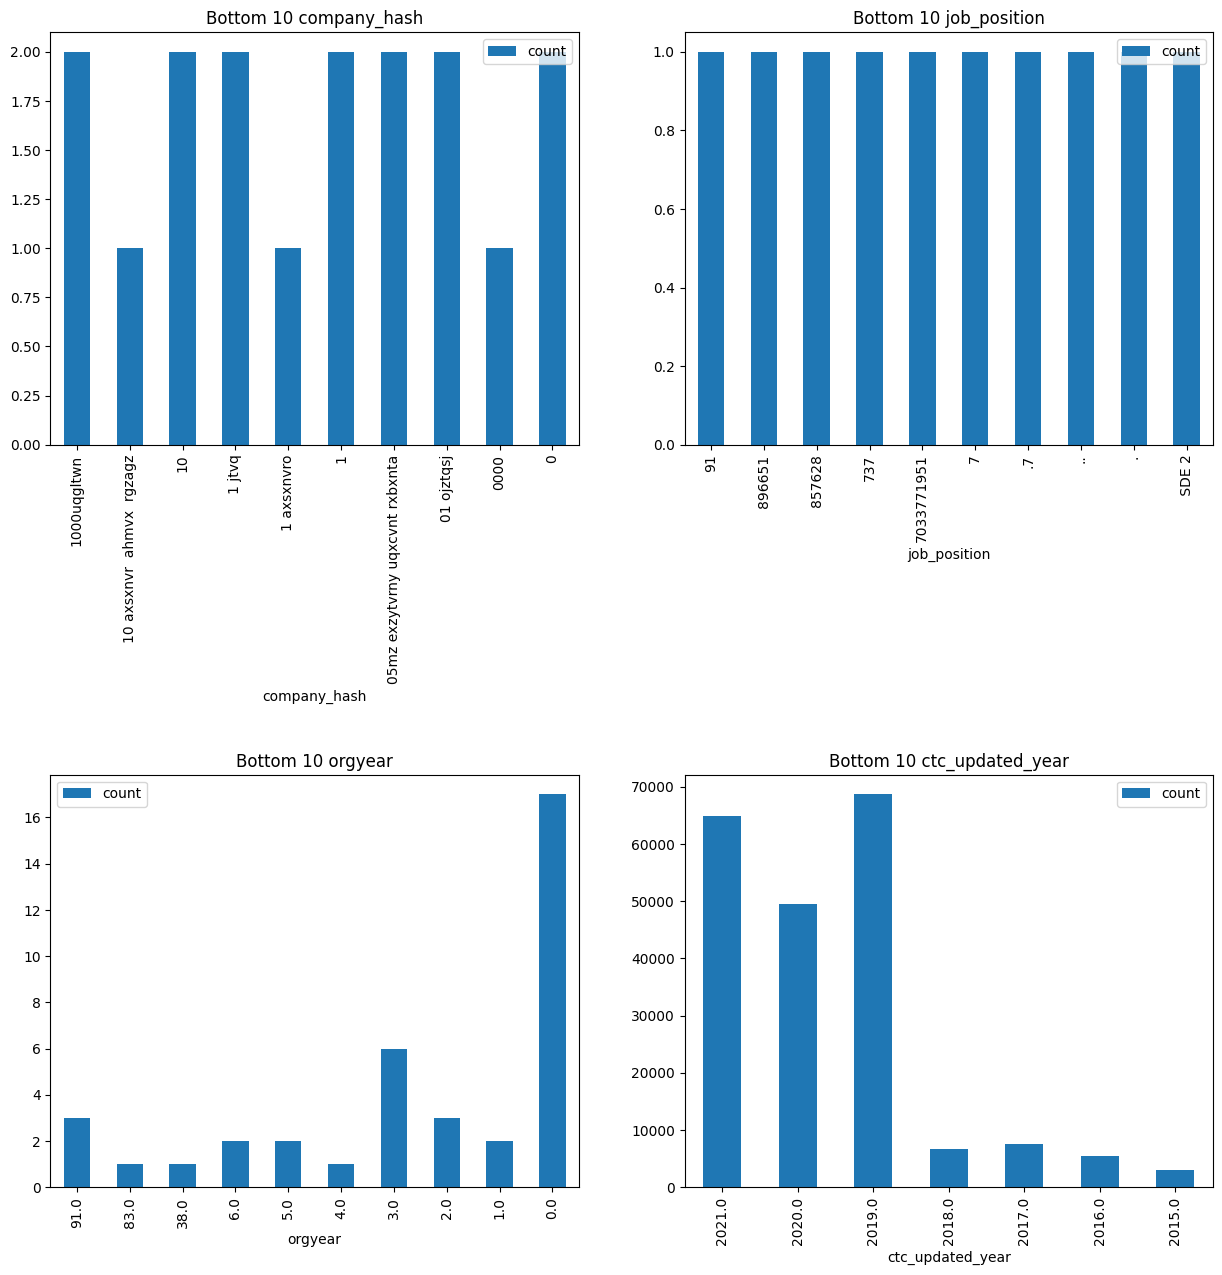

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
plt.subplots_adjust(hspace = .8)
categorical_features = ['company_hash', 'job_position', 'orgyear', 'ctc_updated_year']
for cnt, feature in enumerate(categorical_features):
    axes = ax[cnt//2, cnt%2]
    title = f'Bottom 10 {feature}'
    feature_count = pd.DataFrame(scaler_df[feature].value_counts()).sort_values(by=feature, ascending = False)
    bottom10_datapoints = feature_count.tail(10)
    bottom10_datapoints.plot(kind='bar', ax = axes, title = f'Bottom 10 {feature}')

In [ ]:
print('Mean Salary :', np.mean(scaler_df['ctc']))
print('Median Salary :', np.median(scaler_df['ctc']))
print('Mimimum Salary :', np.min(scaler_df['ctc']))
print('Max Salary :', np.max(scaler_df['ctc']))

Mean Salary : 2271685.0419931696
Median Salary : 950000.0
Mimimum Salary : 2
Max Salary : 1000150000


## Feature Engineering

In [ ]:
# scaler_df_temp = scaler_df.sort_values(by = ['email_hash', 'ctc_updated_year'], ascending = (True, False)).reset_index()

In [ ]:
# scaler_df_temp.isnull().sum()

In [ ]:
# scaler_df_temp[scaler_df_temp['company_hash'].isna()]

In [ ]:
# scaler_df_temp.iloc[6300: 6307]

In [ ]:
# scaler_df_temp['company_hash'] = scaler_df_temp.groupby('email_hash').ffill()
# gidx = scaler_df_temp.groupby('email_hash', sort=False).ngroup()
# scaler_df_temp = scaler_df_temp.groupby(gidx).ffill().groupby(gidx).bfill()

In [ ]:
# scaler_df_temp.iloc[6300: 6307]

### Removing Duplicates

In [ ]:
print('Total Values in Email: ', len(scaler_df['email_hash']))
print('Total Unique Values in Email: ', len(scaler_df['email_hash'].unique()))
print('% of duplicated data in Email: ', (1- len(scaler_df['email_hash'].unique())/ len(scaler_df['email_hash']))*100)

Total Values in Email:  205843
Total Unique Values in Email:  153443
% of duplicated data in Email:  25.456294360264863


In [ ]:
scaler_nodup_df = scaler_df.sort_values(by = ['email_hash', 'ctc_updated_year'], ascending=(True, False))

In [ ]:
scaler_nodup_df[scaler_nodup_df['email_hash'] == '6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c']

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
9857,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2400000,QA Engineer,2020.0
10002,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2400000,Devops Engineer,2020.0
10583,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2400000,Backend Engineer,2020.0
12784,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2400000,Other,2020.0
20715,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2400000,SDET,2020.0
138253,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2000000,SDET,2020.0
159251,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2000000,Devops Engineer,2020.0
165343,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2000000,Other,2020.0
178749,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2000000,Backend Engineer,2020.0


In [ ]:
scaler_nodup_df.drop_duplicates(subset=['email_hash'], keep='first', inplace=True, ignore_index = True)

In [ ]:
scaler_nodup_df

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,bxwqgogen,00003288036a44374976948c327f246fdbdf0778546904...,2012.0,3500000,Backend Engineer,2019.0
1,nqsn axsxnvr,0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...,2013.0,250000,Backend Engineer,2020.0
2,gunhb,0000d58fbc18012bf6fa2605a7b0357d126ee69bc41032...,2021.0,1300000,NaN,2019.0
3,bxwqgotbx wgqugqvnxgz,000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...,2004.0,2000000,FullStack Engineer,2021.0
4,fvrbvqn rvmo,00014d71a389170e668ba96ae8e1f9d991591acc899025...,2009.0,3400000,NaN,2018.0
...,...,...,...,...,...,...
153438,tqxwoogz ogenfvqt wvbuho,fffc254e627e4bd1bc0ed7f01f9aebbba7c3cc56ac914e...,2004.0,3529999,QA Engineer,2019.0
153439,trnqvcg,fffcf97db1e9c13898f4eb4cd1c2fe862358480e104535...,2015.0,1600000,NaN,2018.0
153440,znn avnv srgmvr atrxctqj otqcxwto,fffe7552892f8ca5fb8647d49ca805b72ea0e9538b6b01...,2014.0,900000,Devops Engineer,2019.0
153441,zwq wgqugqvnxgz,ffff49f963e4493d8bbc7cc15365423d84a767259f7200...,2020.0,700000,FullStack Engineer,2020.0


In [ ]:
scaler_nodup_df[scaler_nodup_df['email_hash'] == '6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c']

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
62459,ihvrwgbb,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,2017.0,2400000,QA Engineer,2020.0


In [ ]:
scaler_df.isnull().sum()

company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64

In [ ]:
scaler_nodup_df.isnull().sum()

company_hash           37
email_hash              0
orgyear                83
ctc                     0
job_position        33767
ctc_updated_year        0
dtype: int64

In [ ]:
current_year = dt.now().year
current_year

2024

In [ ]:
scaler_nodup_df['Years of Experience'] = current_year - scaler_nodup_df['orgyear']
scaler_nodup_df['avg sal CJE'] = scaler_nodup_df.groupby(['company_hash', 'job_position', 'Years of Experience'])['ctc'].transform(np.mean)
scaler_nodup_df['avg sal CJ'] = scaler_nodup_df.groupby(['company_hash', 'job_position'])['ctc'].transform(np.mean)
scaler_nodup_df['avg sal C'] = scaler_nodup_df.groupby(['company_hash'])['ctc'].transform(np.mean)

scaler_nodup_df['designation'] = np.where(scaler_nodup_df['ctc'] > scaler_nodup_df['avg sal CJE'], 1, np.where(scaler_nodup_df['ctc'] == scaler_nodup_df['avg sal CJE'], 2, 3))
scaler_nodup_df['Class'] = np.where(scaler_nodup_df['ctc'] > scaler_nodup_df['avg sal CJ'], 1, np.where(scaler_nodup_df['ctc'] == scaler_nodup_df['avg sal CJ'], 2, 3))
scaler_nodup_df['Tier'] = np.where(scaler_nodup_df['ctc'] > scaler_nodup_df['avg sal C'], 1, np.where(scaler_nodup_df['ctc'] == scaler_nodup_df['avg sal C'], 2, 3))

scaler_nodup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153443 entries, 0 to 153442
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_hash         153406 non-null  object 
 1   email_hash           153443 non-null  object 
 2   orgyear              153360 non-null  float64
 3   ctc                  153443 non-null  int64  
 4   job_position         119676 non-null  object 
 5   ctc_updated_year     153443 non-null  float64
 6   Years of Experience  153360 non-null  float64
 7   avg sal CJE          119605 non-null  float64
 8   avg sal CJ           119666 non-null  float64
 9   avg sal C            153406 non-null  float64
 10  designation          153443 non-null  int64  
 11  Class                153443 non-null  int64  
 12  Tier                 153443 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 15.2+ MB


In [ ]:
# scaler_nodup_df[['company_hash', 'job_position', 'Years of Experience']].value_counts().loc[lambda x: x > 2]

In [ ]:
# scaler_nodup_df[(scaler_nodup_df['company_hash'] == 'cxqnhov') & (scaler_nodup_df['job_position'] == 'Backend Engineer') & (scaler_nodup_df['Years of Experience'] == 5)]

In [ ]:
# scaler_nodup_df[(scaler_nodup_df['Tier'] == 1)]

### Top 10 Learners (earning more than most of the employees in the company) - Tier 1

In [ ]:
scaler_nodup_df[scaler_nodup_df['Tier'] == 1].sort_values(by = 'ctc', ascending = False).head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Years of Experience,avg sal CJE,avg sal CJ,avg sal C,designation,Class,Tier
54673,obvqnuqxdwgb,5b4bed51797140db4ed52018a979db1e34cee49e27b488...,2018.0,255555555,NaN,2016.0,6.0,NaN,NaN,5.230311e+07,3,3,1
16423,cxcg bgmxrt xzaxv ucn rna,1b1a39899354f398255dcbef537ed636bc8ce242fab0ea...,2018.0,200000000,NaN,2020.0,6.0,NaN,NaN,3.379000e+07,3,3,1
60472,ogwxvruqvwyvq,64e214237caafc1937f02e8777d2f22a950fa9ace96e94...,2019.0,200000000,Other,2020.0,5.0,2.000000e+08,2.000000e+08,1.006050e+08,2,2,1
14494,vao ogrhnxgz,17d7a7983d8f944459e2d114a99f68634447e552f7aff0...,2017.0,200000000,Other,2020.0,7.0,2.000000e+08,2.000000e+08,6.696667e+07,2,2,1
147703,otre tburgjta,f63e63a8cc3db37c89a49f0498d0731f8c9e2e27943e85...,2015.0,200000000,Android Engineer,2020.0,9.0,6.700000e+07,1.149161e+07,8.150112e+06,1,1,1
109171,tzkxsbv,b61f37e08f24204236994b82c120010a4d98ee2974e44d...,2016.0,200000000,QA Engineer,2020.0,8.0,2.000000e+08,2.000000e+08,1.006000e+08,2,2,1
60759,nvnv wgzohrnvzwj otqcxwto,655da5cd99f1ba4ad249dade5039b914023484fb7f3959...,2017.0,200000000,Data Analyst,2020.0,7.0,1.721375e+07,8.340615e+06,2.099297e+06,1,1,1
87813,btnrxet,928fec0e8c23681d589f4e3d9626f91c189a92137880f9...,2015.0,200000000,QA Engineer,2020.0,9.0,2.000000e+08,1.003000e+08,1.735081e+07,2,1,1
60575,rvqotz nghmqg xzegntwy rna,650d378bf18c2ddcdbbebff5ab90917c510d5c95cf8f32...,2018.0,200000000,Engineering Leadership,2020.0,6.0,2.000000e+08,2.371556e+07,1.805286e+06,2,1,1
109925,znn avnv otqcxwto,b755d7d321b0a55cc94e09654c17f476ca586da0b25978...,2014.0,200000000,Support Engineer,2020.0,10.0,6.713333e+07,1.473000e+07,2.131002e+06,1,1,1


In [ ]:
scaler_nodup_df[scaler_nodup_df['Tier'] == 1].sort_values(by = 'ctc', ascending = False).head(10)['ctc'].agg(['mean', 'median', 'max', 'min'])

mean      205555555.5
median    200000000.0
max       255555555.0
min       200000000.0
Name: ctc, dtype: float64

In [ ]:
scaler_nodup_df[scaler_nodup_df['Tier'] == 1].groupby('job_position')['job_position'].agg('count').sort_values(ascending = False)

job_position
Backend Engineer                8374
FullStack Engineer              3489
Engineering Leadership          3232
Other                           1986
Frontend Engineer               1595
                                ... 
Member of Technical Staff          1
Member of Technical Staff 3        1
Member of technical staff          1
Mobile Application Developer       1
senior software engineer-L2        1
Name: job_position, Length: 191, dtype: int64

In [ ]:
scaler_nodup_df.groupby('job_position')['job_position'].agg('count').sort_values(ascending = False)

job_position
Backend Engineer              33286
FullStack Engineer            17194
Other                         13802
Frontend Engineer              8341
Engineering Leadership         5940
                              ...  
Lead - MIS                        1
Lead Consultant                   1
Lead Consultant Technology        1
Lead Engineer II                  1
technology analyst                1
Name: job_position, Length: 738, dtype: int64

### Bottom 10 Learners (earning less than most of the employees in the company)- Tier 3

In [ ]:
scaler_nodup_df[scaler_nodup_df['Tier'] == 3].sort_values(by = 'ctc', ascending = False).tail(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Years of Experience,avg sal CJE,avg sal CJ,avg sal C,designation,Class,Tier
102314,sgrabvz ovwyo,aaca628b0b240afc71c34e7d5922430dfd3742a4aa53a9...,2020.0,1000,Engineering Intern,2019.0,4.0,1.000000e+03,2.980846e+06,3.173986e+06,2,3,3
151355,uvsotshqg hgr,fc6c6989648ca9a8e78932e583b3f4e6f75a43e0e6c84a...,2015.0,1000,Backend Engineer,2015.0,9.0,1.000000e+03,2.725000e+04,4.222950e+04,2,3,3
35312,zgzt,3ad2638a1ca2f437ae103ebd84905c78aa6735bdabb3df...,2020.0,1000,Other,2020.0,4.0,1.424550e+06,3.707687e+06,5.524688e+06,3,3,3
77015,nvnv wgzohrnvzwj otqcxwto,80ba0259f9f59034c4927cf3bd38dc9ce2eb60ff18135b...,2012.0,600,Backend Engineer,2017.0,12.0,4.483053e+06,1.445723e+06,2.099297e+06,3,3,3
92811,zvz,9af3dca6c9d705d8d42585ccfce2627f00e1629130d14e...,2023.0,600,NaN,2019.0,1.0,NaN,NaN,2.293858e+06,3,3,3
111267,gjg,b995d7a2ae5c6f8497762ce04dc5c04ad6ec734d70802a...,2018.0,600,FullStack Engineer,2021.0,6.0,1.268956e+06,1.340956e+06,2.531827e+06,3,3,3
110681,xm,b8a0bb340583936b5a7923947e9aec21add5ebc50cd60b...,2016.0,15,NaN,2018.0,8.0,NaN,NaN,1.550000e+01,3,3,3
21514,xzntqcxtfmxn,23ad96d6b6f1ecf554a52f6e9b61677c7d73d8a409a143...,2013.0,14,NaN,2018.0,11.0,NaN,NaN,1.408649e+06,3,3,3
145496,xzntqcxtfmxn,f2b58aeed3c074652de2cfd3c0717a5d21d6fbcf342a78...,2013.0,6,NaN,2018.0,11.0,NaN,NaN,1.408649e+06,3,3,3
31852,xzntqcxtfmxn,3505b02549ebe2c95840ac6f0a35561a3b4cbe4b79cdb1...,2014.0,2,Backend Engineer,2019.0,10.0,2.000000e+00,7.373685e+05,1.408649e+06,2,3,3


In [ ]:
scaler_nodup_df[scaler_nodup_df['Tier'] == 3].sort_values(by = 'ctc', ascending = False).tail(10)['ctc'].agg(['mean', 'median', 'max', 'min'])

mean       483.7
median     600.0
max       1000.0
min          2.0
Name: ctc, dtype: float64

In [ ]:
scaler_nodup_df[scaler_nodup_df['Tier'] == 3].groupby('job_position')['job_position'].agg('count').sort_values(ascending = False)

job_position
Backend Engineer                    20878
FullStack Engineer                  10466
Other                                8939
Frontend Engineer                    4709
QA Engineer                          3759
                                    ...  
Management executive                    1
Machine learning engineer               1
Machine Learning Data Associate         1
MTS2                                    1
technology analyst                      1
Name: job_position, Length: 508, dtype: int64

In [ ]:
scaler_nodup_df.groupby('job_position')['job_position'].agg('count').sort_values(ascending = False)

job_position
Backend Engineer              33286
FullStack Engineer            17194
Other                         13802
Frontend Engineer              8341
Engineering Leadership         5940
                              ...  
Lead - MIS                        1
Lead Consultant                   1
Lead Consultant Technology        1
Lead Engineer II                  1
technology analyst                1
Name: job_position, Length: 738, dtype: int64

#### Inference

*   25% of Backend Engineer has more ctc that the average salary companywise
*   1 out of 5 Fullstack developer earns more that average of his counterpart
* The ratio is 1/ 4 among Engineering Leadership when it comes to an earning over avg salary in that department
* Across all the organization, those who earn greater than average salary of the company, earns at a median of 20,00,00,000




### Average Salary per Job title for tier-1 Learners (Earning more than most of the employees in the company)

In [ ]:
scaler_nodup_df[scaler_nodup_df['Tier'] == 1].groupby(['job_position'])['ctc'].agg('mean').astype('int64').sort_values(ascending = False)

job_position
7033771951                                    100000000
Student                                       100000000
Jharkhand                                     100000000
Computer Scientist 2                          100000000
Owner                                         100000000
                                                ...    
Big data Developer                               300000
Director Engineering                             187500
Mobile Application Engineer(Android & iOS)       100000
Associate Application Engineer                    85000
Researcher                                        50000
Name: ctc, Length: 191, dtype: int64

### Average Salary per Job title for tier-3 Learners (Earning less than most of the employees in the company)

In [ ]:
scaler_nodup_df[scaler_nodup_df['Tier'] == 3].groupby(['job_position'])['ctc'].agg('mean').astype('int64').sort_values(ascending = False)

job_position
SDE-II                                                             3400000
Applied Scientist II                                               3300000
SDE-I                                                              3225000
Software / web developer                                           3200000
System Software engineer                                           3000000
                                                                    ...   
Junior consultant                                                    10000
Some data entry operator like some copy's write.type and upload      10000
Any technical                                                        10000
New graduate                                                          2000
Technical consultant                                                  2000
Name: ctc, Length: 508, dtype: int64

### Top 10 Learners (earning More than most of the employees in the company and Department) - Class 1

In [ ]:
scaler_nodup_df[scaler_nodup_df['Class'] == 1].sort_values(by = 'ctc', ascending = False).head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Years of Experience,avg sal CJE,avg sal CJ,avg sal C,designation,Class,Tier
13837,ntwy bvyxzaqv,16b1e23c22e9162f476ec3639ce875b0cc88678cc671e2...,2013.0,200000000,Support Engineer,2020.0,11.0,1.002500e+08,1.116263e+07,3.916901e+06,1,1,1
32291,sggsrt,35cabddba75a014e0fced77203b5653630b0f49a27f3b3...,2019.0,200000000,FullStack Engineer,2020.0,5.0,5.317500e+07,2.008254e+07,6.276286e+06,1,1,1
60759,nvnv wgzohrnvzwj otqcxwto,655da5cd99f1ba4ad249dade5039b914023484fb7f3959...,2017.0,200000000,Data Analyst,2020.0,7.0,1.721375e+07,8.340615e+06,2.099297e+06,1,1,1
152409,eqttrvzwtq,fe2c448bc7d2b5a523864ef3a4bc5d4b3f3af390a66984...,2022.0,200000000,Other,2020.0,2.0,1.002000e+08,1.835122e+07,5.616310e+06,1,1,1
17242,stzuvwn,1c6bc8b95225bf255f939a64f9d60f84371f16eb621f3a...,2014.0,200000000,Other,2020.0,10.0,2.919857e+07,9.899902e+06,2.859244e+06,1,1,1
32316,qmo,35d4845547c5d2e0c2eadc197c97c678035bceb5fddd2d...,2015.0,200000000,Data Analyst,2020.0,9.0,1.002000e+08,4.073000e+07,4.090128e+06,1,1,1
2100,mvzp ge vbtqxwv,0391b9c03e6601ce26e7257e6b9eb80a49304123a05217...,2014.0,200000000,Devops Engineer,2020.0,10.0,1.002467e+08,3.910962e+07,4.391161e+06,1,1,1
21224,zgzt,232e5b21da629a8acb3bdef7b49e57b28fc3bf64ae2687...,2023.0,200000000,Engineering Leadership,2020.0,1.0,1.005500e+08,5.082667e+07,5.524688e+06,1,1,1
21153,xwxwx mvzp,2311bf023218afe93d650cac03abb7a40f7fa55c08d260...,2018.0,200000000,Other,2020.0,6.0,6.683333e+07,1.517838e+07,8.845115e+06,1,1,1
131397,bgngqgrv bgmxrxnj v rtzgcg wgbuvzj,db521de92d35c3a817bca9e6c0bc9482703b40d53cefc2...,2021.0,200000000,Other,2020.0,3.0,2.000000e+08,1.003700e+08,1.012217e+07,2,1,1


In [ ]:
scaler_nodup_df[scaler_nodup_df['Class'] == 1].sort_values(by = 'ctc', ascending = False).head(10)['ctc'].agg(['mean', 'median', 'max', 'min'])

mean      200000000.0
median    200000000.0
max       200000000.0
min       200000000.0
Name: ctc, dtype: float64

### Bottom 10 Learners (earning less than most of the employees in the company and Department)- Class 3

In [ ]:
scaler_nodup_df[scaler_nodup_df['Class'] == 3].sort_values(by = 'ctc', ascending = False).tail(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Years of Experience,avg sal CJE,avg sal CJ,avg sal C,designation,Class,Tier
80279,nvnv wgzohrnvzwj otqcxwto,8625d6d072e12dad0c5748ab010e1d0315736a359e2bb5...,2013.0,1000,Frontend Engineer,2021.0,11.0,8.713750e+05,1.008727e+06,2.099297e+06,3,3,3
74464,mtznrtj ojontbo,7c8e0d8194db4deb41cbc9b3b6c428e0f9ab289436638e...,2016.0,1000,FullStack Engineer,2019.0,8.0,1.000000e+03,4.302500e+05,6.469999e+05,2,3,3
77015,nvnv wgzohrnvzwj otqcxwto,80ba0259f9f59034c4927cf3bd38dc9ce2eb60ff18135b...,2012.0,600,Backend Engineer,2017.0,12.0,4.483053e+06,1.445723e+06,2.099297e+06,3,3,3
92811,zvz,9af3dca6c9d705d8d42585ccfce2627f00e1629130d14e...,2023.0,600,NaN,2019.0,1.0,NaN,NaN,2.293858e+06,3,3,3
111267,gjg,b995d7a2ae5c6f8497762ce04dc5c04ad6ec734d70802a...,2018.0,600,FullStack Engineer,2021.0,6.0,1.268956e+06,1.340956e+06,2.531827e+06,3,3,3
70106,xm,75357254a31f133e2d3870057922feddeba82b88056a07...,2019.0,16,NaN,2018.0,5.0,NaN,NaN,1.550000e+01,3,3,1
110681,xm,b8a0bb340583936b5a7923947e9aec21add5ebc50cd60b...,2016.0,15,NaN,2018.0,8.0,NaN,NaN,1.550000e+01,3,3,3
21514,xzntqcxtfmxn,23ad96d6b6f1ecf554a52f6e9b61677c7d73d8a409a143...,2013.0,14,NaN,2018.0,11.0,NaN,NaN,1.408649e+06,3,3,3
145496,xzntqcxtfmxn,f2b58aeed3c074652de2cfd3c0717a5d21d6fbcf342a78...,2013.0,6,NaN,2018.0,11.0,NaN,NaN,1.408649e+06,3,3,3
31852,xzntqcxtfmxn,3505b02549ebe2c95840ac6f0a35561a3b4cbe4b79cdb1...,2014.0,2,Backend Engineer,2019.0,10.0,2.000000e+00,7.373685e+05,1.408649e+06,2,3,3


In [ ]:
scaler_nodup_df[scaler_nodup_df['Class'] == 3].sort_values(by = 'ctc', ascending = False).tail(10)['ctc'].agg(['mean', 'median', 'max', 'min'])

mean       385.3
median     308.0
max       1000.0
min          2.0
Name: ctc, dtype: float64

### Average Salary per Job title for Class-1 Learners (Earning more than most of the employees in the company and department)

In [ ]:
scaler_nodup_df[scaler_nodup_df['Class'] == 1].groupby(['job_position'])['ctc'].agg('mean').astype('int64').sort_values(ascending = False)

job_position
Security Leadership          33434166
Support Engineer             15249312
Other                        14177538
Non Coder                    13220545
Data Analyst                 12878196
                               ...   
Programmer Analyst             466666
Senior Systems Engineer        425000
Assistant System Engineer      387500
Na                             340000
Software Engineer II           110000
Name: ctc, Length: 63, dtype: int64

### Average Salary per Job title for Class-3 Learners (Earning less than most of the employees in the company and department)

In [ ]:
scaler_nodup_df[scaler_nodup_df['Class'] == 3].groupby(['job_position'])['ctc'].agg('mean').astype('int64').sort_values(ascending = False)

job_position
MTS2                         2800000
Member of Technical Staff    2450000
Backend Architect            2301963
Engineering Leadership       2130108
SDE 1                        2050000
                              ...   
ASE                           310000
System engineer               285000
Assistant System Engineer     261333
Software Engineer II          100000
Technology Analyst             73000
Name: ctc, Length: 63, dtype: int64

### Top 10 Learners (earning More than most of the employees in the company + Department + year of exp) - Desig 1

In [ ]:
scaler_nodup_df[scaler_nodup_df['designation'] == 1].sort_values(by = 'ctc', ascending = False).head(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Years of Experience,avg sal CJE,avg sal CJ,avg sal C,designation,Class,Tier
135572,ntvwyxzs,e2484d86abe9d5e2f21f43dbf0c6ad802d2f9fda71af0c...,2016.0,200000000,Other,2020.0,8.0,1.000500e+08,3.349500e+07,3.349500e+07,1,1,1
19263,xzatstzt tzwxbv,1fe9990319dc839ee1d74ceb8ff599ffa4fda6e9fd5666...,2016.0,200000000,Frontend Engineer,2020.0,8.0,1.001800e+08,3.385000e+07,8.120357e+06,1,1,1
121831,nyxzp rtvqz ucn rna mjlho,cb64586cd92d69054743a04000f17f7cc9fb70be044085...,2016.0,200000000,Other,2020.0,8.0,2.311000e+07,4.789175e+06,3.553151e+06,1,1,1
109925,znn avnv otqcxwto,b755d7d321b0a55cc94e09654c17f476ca586da0b25978...,2014.0,200000000,Support Engineer,2020.0,10.0,6.713333e+07,1.473000e+07,2.131002e+06,1,1,1
96085,vwwtznhqt,a071c4cd6d423e8d1841ba6133e6c4684f4eaba7dc1526...,2017.0,200000000,Backend Engineer,2020.0,7.0,4.339259e+06,2.329460e+06,2.701076e+06,1,1,1
128011,nvnv wgzohrnvzwj otqcxwto,d5abf1ac1dfe43a6297001c513b67e7f69d95c71ee9249...,2015.0,200000000,Other,2020.0,9.0,8.066549e+06,3.071607e+06,2.099297e+06,1,1,1
39012,fxuqg rxbxnta,4122d244a29e3de69d4a9c30de05c78e6547278a593b3a...,2020.0,200000000,Other,2020.0,4.0,9.519485e+06,2.146973e+06,2.689089e+06,1,1,1
53363,nvnv wgzohrnvzwj otqcxwto,59316048d113539202325e05af9b66620255ba84eab635...,2015.0,200000000,Data Analyst,2020.0,9.0,2.211350e+07,8.340615e+06,2.099297e+06,1,1,1
53953,gnytq,5a22951df9377bc13dab9bd4771ee7d0bbd7e639d2f81b...,2015.0,200000000,Frontend Engineer,2020.0,9.0,6.702667e+07,5.032700e+07,1.089909e+07,1,1,1
54094,xzegojo,5a62c4492a39b13d825bdd372b9891103252b816818b43...,2011.0,200000000,Other,2020.0,13.0,2.913400e+07,1.906279e+06,1.618057e+06,1,1,1


In [ ]:
scaler_nodup_df[scaler_nodup_df['designation'] == 1].sort_values(by = 'ctc', ascending = False).head(10)['ctc'].agg(['mean', 'median', 'max', 'min'])

mean      200000000.0
median    200000000.0
max       200000000.0
min       200000000.0
Name: ctc, dtype: float64

### Bottom 10 Learners (earning less than most of the employees in the company + Department + year of experience)- Designation 3

In [ ]:
scaler_nodup_df[scaler_nodup_df['designation'] == 3].sort_values(by = 'ctc', ascending = False).tail(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,Years of Experience,avg sal CJE,avg sal CJ,avg sal C,designation,Class,Tier
104456,kvrgqv sqghu,ae625c7063c1f8194deadfb28905d5dcc6f9077274a083...,2017.0,1000,Backend Engineer,2021.0,7.0,2.050000e+04,1.866667e+04,1.866667e+04,3,3,3
109280,zvz,b64eef23f6fc36f095565cba6180fde79ef7da7faf1f8b...,2013.0,1000,Backend Engineer,2021.0,11.0,7.938000e+05,2.654818e+06,2.293858e+06,3,3,3
84433,zgn vuurxwvmrt vwwghzn,8d1e069a03fc437876b406b8c93bc7e07577f9836222bd...,2021.0,1000,NaN,2021.0,3.0,NaN,NaN,2.931588e+06,3,3,3
92811,zvz,9af3dca6c9d705d8d42585ccfce2627f00e1629130d14e...,2023.0,600,NaN,2019.0,1.0,NaN,NaN,2.293858e+06,3,3,3
77015,nvnv wgzohrnvzwj otqcxwto,80ba0259f9f59034c4927cf3bd38dc9ce2eb60ff18135b...,2012.0,600,Backend Engineer,2017.0,12.0,4.483053e+06,1.445723e+06,2.099297e+06,3,3,3
111267,gjg,b995d7a2ae5c6f8497762ce04dc5c04ad6ec734d70802a...,2018.0,600,FullStack Engineer,2021.0,6.0,1.268956e+06,1.340956e+06,2.531827e+06,3,3,3
70106,xm,75357254a31f133e2d3870057922feddeba82b88056a07...,2019.0,16,NaN,2018.0,5.0,NaN,NaN,1.550000e+01,3,3,1
110681,xm,b8a0bb340583936b5a7923947e9aec21add5ebc50cd60b...,2016.0,15,NaN,2018.0,8.0,NaN,NaN,1.550000e+01,3,3,3
21514,xzntqcxtfmxn,23ad96d6b6f1ecf554a52f6e9b61677c7d73d8a409a143...,2013.0,14,NaN,2018.0,11.0,NaN,NaN,1.408649e+06,3,3,3
145496,xzntqcxtfmxn,f2b58aeed3c074652de2cfd3c0717a5d21d6fbcf342a78...,2013.0,6,NaN,2018.0,11.0,NaN,NaN,1.408649e+06,3,3,3


In [ ]:
scaler_nodup_df[scaler_nodup_df['designation'] == 3].sort_values(by = 'ctc', ascending = False).tail(10)['ctc'].agg(['mean', 'median', 'max', 'min'])

mean       485.1
median     600.0
max       1000.0
min          6.0
Name: ctc, dtype: float64

### Average Salary per Job title for Designation-1 Learners (Earning more than most of the employees in the company + department + year of experience)

In [ ]:
scaler_nodup_df[scaler_nodup_df['designation'] == 1].groupby(['job_position'])['ctc'].agg('mean').astype('int64').sort_values(ascending = False)

job_position
Product Manager                      10471052
Data Analyst                         10325772
Other                                 9715867
Non Coder                             9405624
Support Engineer                      9016119
Engineering Leadership                5799922
Backend Architect                     4404432
Frontend Engineer                     4163943
Android Engineer                      4146534
Engineering Intern                    4121762
FullStack Engineer                    3559414
MTS2                                  3500000
Co-founder                            3463750
Backend Engineer                      3438488
QA Engineer                           3214815
Lead Software Engineer                3100000
Research Engineers                    3082099
Intern                                3025000
Program Manager                       2807529
Devops Engineer                       2353716
Data Scientist                        2308342
Product Designer     

### Average Salary per Job title for designation-3 Learners (Earning less than most of the employees in the company and department)

In [ ]:
scaler_nodup_df[scaler_nodup_df['designation'] == 3].groupby(['job_position'])['ctc'].agg('mean').astype('int64').sort_values(ascending = False)

job_position
MTS2                                 2800000
Backend Architect                    2483266
Engineering Leadership               2412744
Intern                               2000000
Program Manager                      1898263
Product Manager                      1845500
Lead Software Engineer               1600000
Software Development Engineer - I    1500000
Security Leadership                  1500000
Product Designer                     1270000
Research Engineers                   1202186
Backend Engineer                     1134320
Engineering Intern                   1118265
iOS Engineer                         1116709
Android Engineer                     1059503
Devops Engineer                      1054495
Data Scientist                       1022135
Fullstack Engineer                   1009199
Co-founder                            988444
FullStack Engineer                    926387
SDET                                  851076
Frontend Engineer                     8390

### Average Data Scientist ctc for tier - 1 and tier - 3

In [ ]:
scaler_nodup_df[scaler_nodup_df['job_position'] == 'Data Scientist'].groupby('Tier')['ctc'].agg('mean').astype('int64')

Tier
1    3591612
2    1881542
3    1088974
Name: ctc, dtype: int64

## Data Preprocessing

In [ ]:
x_scaler_df = scaler_nodup_df.drop(columns=['ctc'])
y_scaler_df = scaler_nodup_df['ctc']

In [ ]:
encoder = TargetEncoder(return_df = True)

In [ ]:
scaler_encode_df = encoder.fit_transform(x_scaler_df, y_scaler_df)
scaler_encode_df['ctc'] = y_scaler_df
scaler_encode_df.head()

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,Years of Experience,avg sal CJE,avg sal CJ,avg sal C,designation,Class,Tier,ctc
0,3.406266e+06,2.645845e+06,2012.0,2.102491e+06,2019.0,12.0,3216468.75,3.167033e+06,3.406266e+06,1,1,1,3500000
1,2.222993e+06,2.222993e+06,2013.0,2.102491e+06,2020.0,11.0,250000.00,2.500000e+05,2.500000e+05,2,2,2,250000
2,1.467001e+06,2.359606e+06,2021.0,2.284519e+06,2019.0,3.0,NaN,NaN,1.467000e+06,3,3,3,1300000
3,2.289373e+06,2.450682e+06,2004.0,2.082270e+06,2021.0,20.0,2000000.00,1.067500e+06,1.726818e+06,2,1,1,2000000
4,2.783045e+06,2.632834e+06,2009.0,2.284519e+06,2018.0,15.0,NaN,NaN,2.783045e+06,3,3,1,3400000


In [ ]:
scaler_encode_df.isna().sum()

company_hash               0
email_hash                 0
orgyear                   83
job_position               0
ctc_updated_year           0
Years of Experience       83
avg sal CJE            33838
avg sal CJ             33777
avg sal C                 37
designation                0
Class                      0
Tier                       0
ctc                        0
dtype: int64

In [ ]:
def restore_nan(source_df, target_df, series):
    target_df[series] = np.where(source_df[series].isna(), np.NaN, target_df[series])

In [ ]:
restore_nan(scaler_nodup_df, scaler_encode_df, 'company_hash')
restore_nan(scaler_nodup_df, scaler_encode_df, 'orgyear')
restore_nan(scaler_nodup_df, scaler_encode_df, 'job_position')

In [ ]:
scaler_encode_df.isna().sum()

company_hash              37
email_hash                 0
orgyear                   83
job_position           33767
ctc_updated_year           0
Years of Experience       83
avg sal CJE            33838
avg sal CJ             33777
avg sal C                 37
designation                0
Class                      0
Tier                       0
ctc                        0
dtype: int64

In [ ]:
imputer = KNNImputer(n_neighbors=1)
col_list = scaler_encode_df.columns.drop(['avg sal CJE', 'avg sal CJ', 'avg sal C']).tolist()
col_list

['company_hash',
 'email_hash',
 'orgyear',
 'job_position',
 'ctc_updated_year',
 'Years of Experience',
 'designation',
 'Class',
 'Tier',
 'ctc']

In [ ]:
scaler_impute_df = pd.DataFrame(imputer.fit_transform(scaler_encode_df[col_list]), columns=col_list)
scaler_impute_df.head()

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,Years of Experience,designation,Class,Tier,ctc
0,3.406266e+06,2.645845e+06,2012.0,2.102491e+06,2019.0,12.0,1.0,1.0,1.0,3500000.0
1,2.222993e+06,2.222993e+06,2013.0,2.102491e+06,2020.0,11.0,2.0,2.0,2.0,250000.0
2,1.467001e+06,2.359606e+06,2021.0,2.102491e+06,2019.0,3.0,3.0,3.0,3.0,1300000.0
3,2.289373e+06,2.450682e+06,2004.0,2.082270e+06,2021.0,20.0,2.0,1.0,1.0,2000000.0
4,2.783045e+06,2.632834e+06,2009.0,4.703296e+06,2018.0,15.0,3.0,3.0,1.0,3400000.0


In [ ]:
scaler_impute_df.isna().sum()

company_hash           0
email_hash             0
orgyear                0
job_position           0
ctc_updated_year       0
Years of Experience    0
designation            0
Class                  0
Tier                   0
ctc                    0
dtype: int64

In [ ]:
starderd_obj = MinMaxScaler()

In [ ]:
scaler_std_df = pd.DataFrame(starderd_obj.fit_transform(scaler_impute_df), columns = col_list)
scaler_std_df.head(10)

,company_hash,email_hash,orgyear,job_position,ctc_updated_year,Years of Experience,designation,Class,Tier,ctc
0,0.021725,0.003499,0.099777,0.066173,0.666667,0.900223,0.0,0.0,0.0,0.003499
1,0.012746,0.000250,0.099826,0.066173,0.833333,0.900174,0.5,0.5,0.5,0.000250
2,0.007009,0.001300,0.100223,0.066173,0.666667,0.899777,1.0,1.0,1.0,0.001300
3,0.013249,0.002000,0.099380,0.064778,1.000000,0.900620,0.5,0.0,0.0,0.002000
4,0.016996,0.003399,0.099628,0.245622,0.500000,0.900372,1.0,1.0,0.0,0.003399
5,0.011807,0.000450,0.100074,0.299049,1.000000,0.899926,0.0,1.0,1.0,0.000450
6,0.013239,0.000750,0.099975,0.056846,0.833333,0.900025,0.5,0.5,0.5,0.000750
7,0.014770,0.002300,0.099727,0.245622,1.000000,0.900273,0.5,0.5,0.5,0.002300
8,0.004336,0.001800,0.099777,0.005143,1.000000,0.900223,0.5,0.0,0.0,0.001800
9,0.015954,0.003499,0.100025,0.257118,1.000000,0.899975,1.0,1.0,0.5,0.003499


<Axes: xlabel='company_hash', ylabel='ctc'>

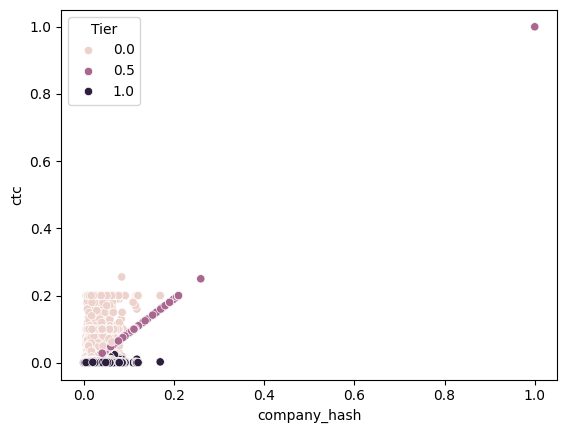

In [ ]:
sns.scatterplot(data= scaler_std_df, x = 'company_hash', y = 'ctc', hue = 'Tier')

<Axes: xlabel='company_hash', ylabel='ctc'>

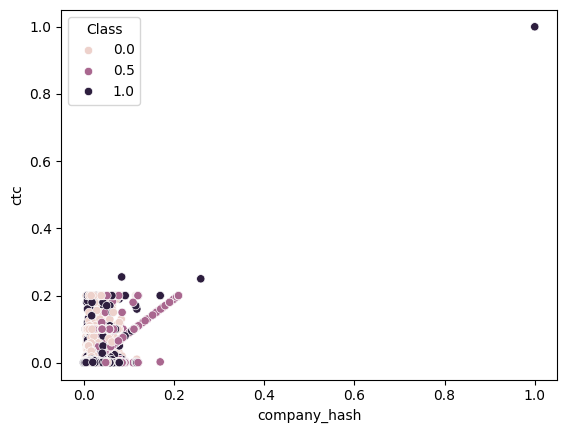

In [ ]:
sns.scatterplot(data= scaler_std_df, x = 'company_hash', y = 'ctc', hue = 'Class')

## Unsupervised Learning - Clustering

Dropping below columns
* email_hash : Unique ID
* orgyear    : Collinear with 'Years of Experience'


In [ ]:
scaler_processed_df = scaler_std_df.drop(columns = ['email_hash', 'orgyear'], axis = 1)
scaler_processed_df.head()

,company_hash,job_position,ctc_updated_year,Years of Experience,designation,Class,Tier,ctc
0,0.021725,0.066173,0.666667,0.900223,0.0,0.0,0.0,0.003499
1,0.012746,0.066173,0.833333,0.900174,0.5,0.5,0.5,0.000250
2,0.007009,0.066173,0.666667,0.899777,1.0,1.0,1.0,0.001300
3,0.013249,0.064778,1.000000,0.900620,0.5,0.0,0.0,0.002000
4,0.016996,0.245622,0.500000,0.900372,1.0,1.0,0.0,0.003399


### K Means Clustering

In [ ]:
km_obj = KMeans(n_clusters= 3, init = 'k-means++')

In [ ]:
k_cluster = km_obj.fit(scaler_processed_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# ax.plot(scaler_processed_df[scaler_processed_df.columns[:-1]], k_cluster)
# plt.show()

In [ ]:
print('WCSS value is :', k_cluster.inertia_)

WCSS value is : 33312.286009269716


In [ ]:
inertia_list = []
for i in range(1, 11):
  km_obj = KMeans(n_clusters= i, init = 'k-means++')
  k_cluster = km_obj.fit(scaler_processed_df)
  inertia_list.append(k_cluster.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

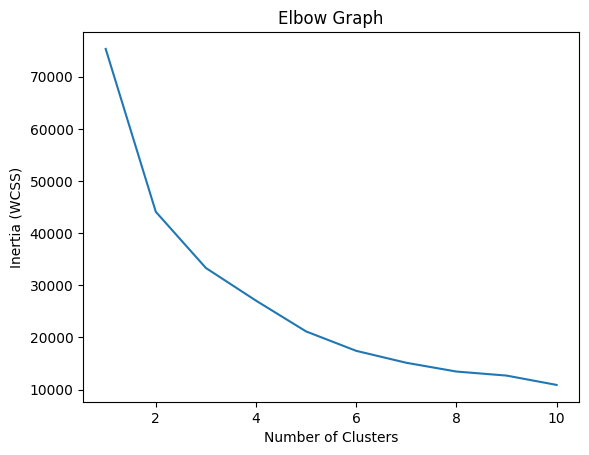

In [ ]:
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.show()

In [ ]:
km_obj = KMeans(n_clusters= 7, init = 'k-means++')
k_cluster = km_obj.fit_predict(scaler_processed_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,company_hash,job_position,ctc_updated_year,Years of Experience,designation,Class,Tier,ctc
label,,,,,,,,
0,0.012653,0.110525,0.747504,0.900118,0.908395,0.999289,0.037276,0.005504
1,0.014862,0.093333,0.509898,0.900026,0.983302,0.999842,0.988041,0.000996
2,0.012890,0.099315,0.735142,0.900230,0.362659,0.157276,0.000000,0.006690
3,0.015496,0.099802,0.732218,0.900163,0.486068,0.514385,0.485656,0.003103
4,0.015281,0.091292,0.731061,0.900103,0.421620,0.252528,1.000000,0.001176
5,0.014922,0.098396,0.774868,0.900067,0.299916,1.000000,1.000000,0.001008
6,0.015425,0.117156,0.927911,0.900012,1.000000,0.999908,0.950268,0.001036


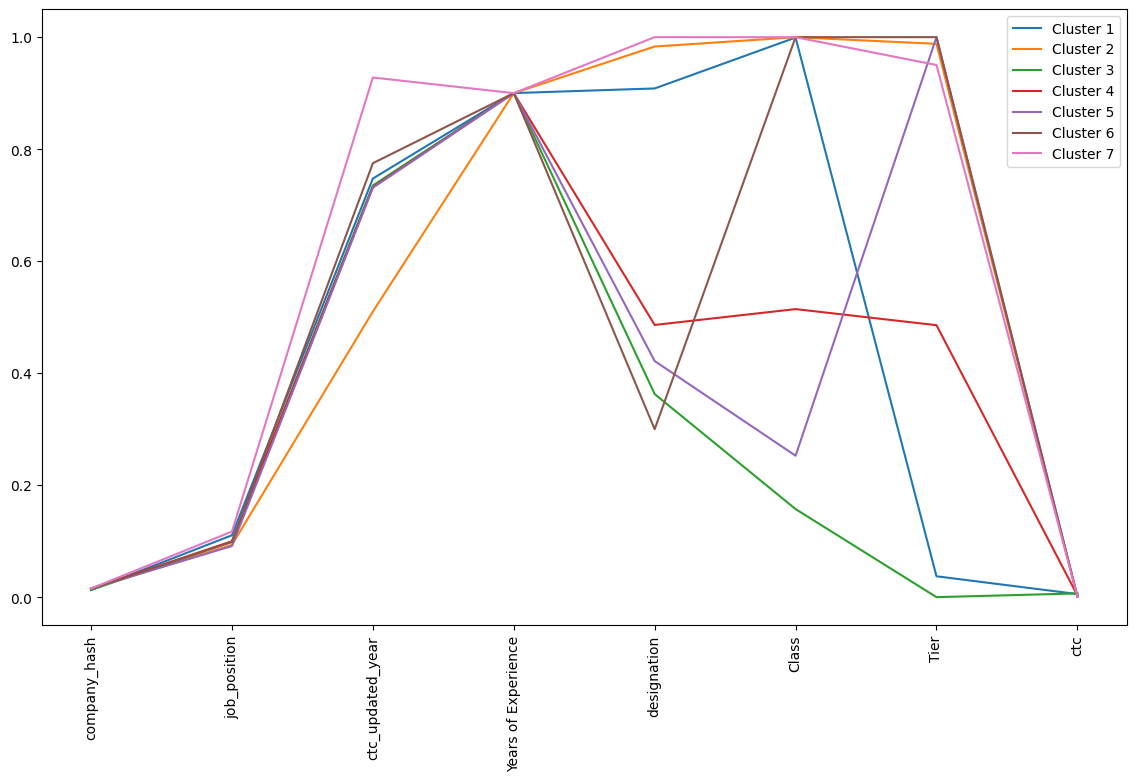

In [ ]:
scaler_processed_df_km = scaler_processed_df.copy()
scaler_processed_df_km['label'] = pd.Series(k_cluster, index=scaler_processed_df.index)

clustered_df = scaler_processed_df_km.groupby('label').mean()

labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7']

plt.figure(figsize=(14,8))
plt.plot(clustered_df.T, label=labels)
plt.xticks(rotation=90)
plt.legend(labels)
clustered_df

In [ ]:
# print('WCSS value is :', k_cluster.inertia_)

### Agglomerative Clustering

In [ ]:
agm_obj = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidian', linkage='ward')

In [ ]:
scaler_processed_df.head()

,company_hash,job_position,ctc_updated_year,Years of Experience,designation,Class,Tier,ctc
0,0.021725,0.066173,0.666667,0.900223,0.0,0.0,0.0,0.003499
1,0.012746,0.066173,0.833333,0.900174,0.5,0.5,0.5,0.000250
2,0.007009,0.066173,0.666667,0.899777,1.0,1.0,1.0,0.001300
3,0.013249,0.064778,1.000000,0.900620,0.5,0.0,0.0,0.002000
4,0.016996,0.245622,0.500000,0.900372,1.0,1.0,0.0,0.003399


In [ ]:
scaler_processed_df_samp = scaler_processed_df.iloc[:10000]

In [ ]:
hierarchy_label = hierarchy.linkage(scaler_processed_df_samp, method='ward')

In [ ]:
hierarchy_label.shape

(9999, 4)

1.23 s ± 210 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0, 0.5, 'distance')

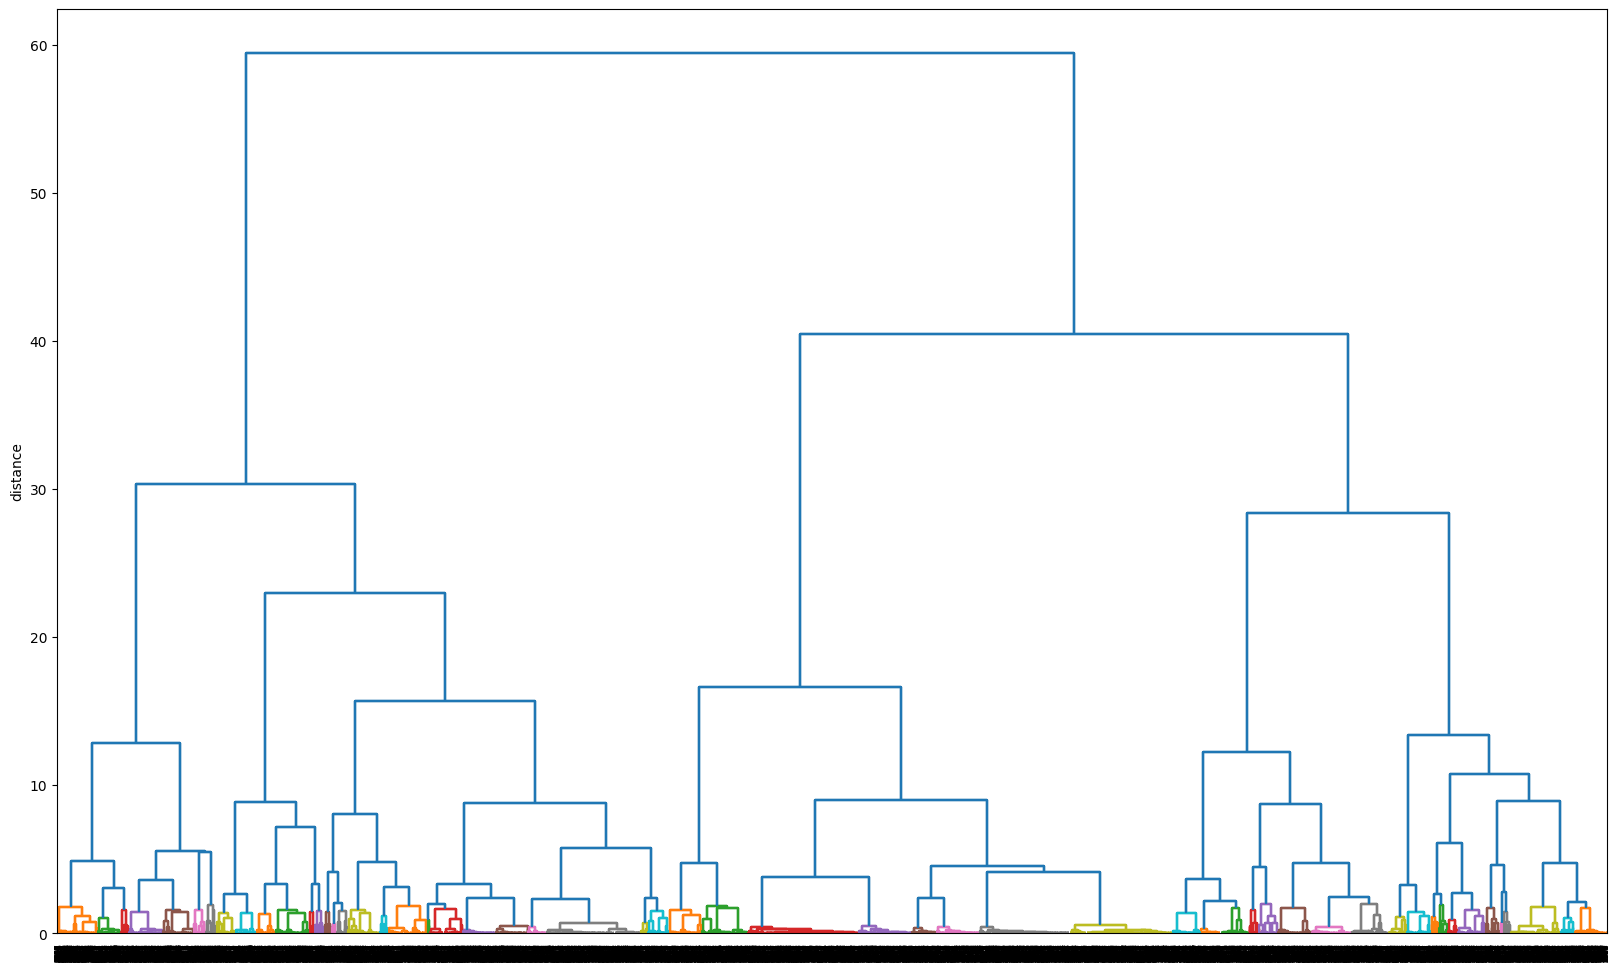

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
%timeit hierarchy.dendrogram(hierarchy_label, labels=scaler_processed_df_samp.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

## Insights and Recommendation

*   25% of Backend Engineer has more ctc that the average salary companywise
*   1 out of 5 Fullstack developer earns more that average of his counterpart
* The ratio is 1/ 4 among Engineering Leadership when it comes to an earning over avg salary in that department
* Across all the organization, those who earn greater than average salary of the company, earns at a median of 20,00,00,000
* By the provided data, it appears that it'll be best to categorize learners into 7 clusters

1. Learners with high level of exp and high class (income is above the average of peers at their job level) but at low tier(income less that avg income of companies)
 * Recommended strategy: Based on their performance, shortlist them for top tier MNCs or role change opportunity.

2. Learners with high level of exp + High class(income is above the average of peers at their job level)  + High tier (income higher than avg income at company level)
 * Recommended strategy: Best cohort for research related roles

3. Learners with high level of exp + Low class(income is lower the average of peers at their job level)  + Low tier (income lower than avg income at company level)
 * Recommended strategy: Career Progression within same / similar company

4. Learners with high level of exp + Moderate class(income is lower the average of peers at their job level)  + Moderate tier (income lower than avg income at company level)
 * Recommended strategy: Career Progression in different company (service based <—> product based)

5. Learners with no-CTC update over longer duration + Low class(income is lower than average of peers at their job level)  + High tier (income lower than avg income at company level)
 * Recommended strategy: Any kind of switch with higher CTC increment

6. Learners with Low department (income is lower the average of peers at their job level with same exp level)  + High class (income is higher than average of peers at their job level)
 * Recommended strategy: Promotion in the job designation

7. Learners with Low Class (income is lower the average of peers at their job level with same exp level)  + High Tier (income is higher than average of peers at their job level)
 * Recommended strategy: Role change within same company

